In [12]:
import numpy as np
from scipy import stats
from scipy.stats import norm
import matplotlib.pyplot as plt

Fourier: 2nd-level uniformity test: p=0.000 -> FAIL
first-level tests passed: 1000
p-values avg: 0.405, frequencies mean: 5.000, frequencies std: 21.157
KS: 2nd-level uniformity test: p=0.242 -> PASS
first-level tests passed: 960
p-values avg: 0.513, frequencies mean: 5.000, frequencies std: 2.120


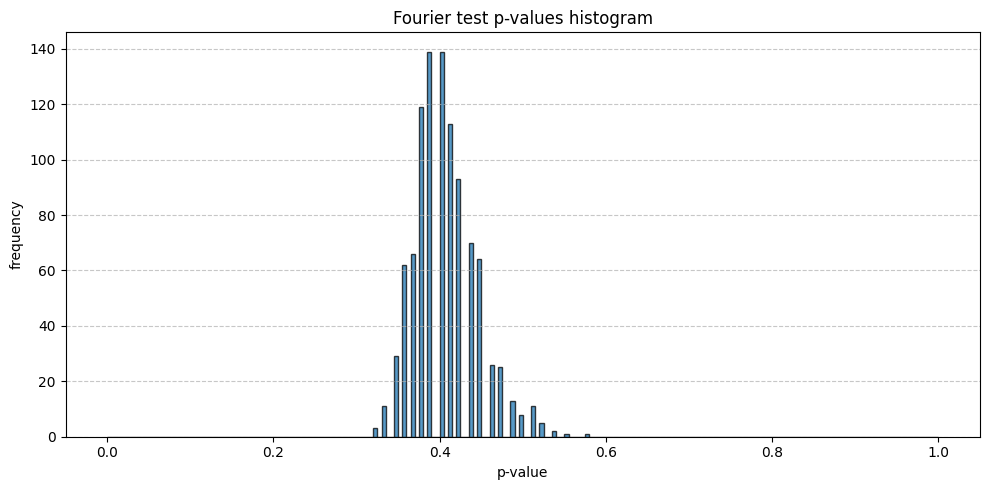

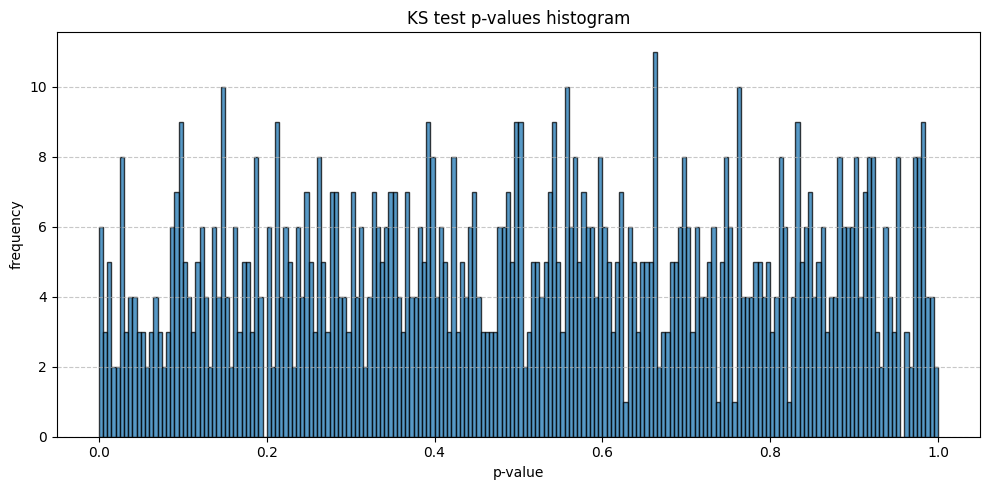

In [23]:
SIGNIFICANCE_LEVEL = 0.05

# MT (https://numpy.org/doc/2.2/reference/random/generator.html#numpy.random.Generator)
np.random.seed(42)


def test_normal_distribution(significance_level=SIGNIFICANCE_LEVEL):
  samples = np.random.normal(loc=0, scale=1, size=100000)
  ks_stat, ks_pvalue = stats.kstest(samples, 'norm')
  return ks_pvalue, (ks_pvalue >= SIGNIFICANCE_LEVEL)


def dft_test(bits, significance_level=SIGNIFICANCE_LEVEL):
  # convert bits to -1 and 1 sequence
  x = np.array(bits) * 2 - 1
  n = x.size
  S = np.fft.fft(x)
  M = np.abs(S)[:n >> 1]  # only first n/2 frequencies
  T = np.sqrt(np.log(1 / significance_level) * n)

  # count peaks below threshold
  N0 = 0.001 * n / 2.0
  N1 = np.count_nonzero(M < T)

  # compute test statistic d and p-value
  d = (N1 - N0) / np.sqrt(n *
                          (1 - significance_level) * significance_level / 2.0)
  p_value = 2 * norm.sf(abs(d))
  return p_value, (p_value >= significance_level)


def second_level_uniformity_test(p_values,
                                 significance_level=SIGNIFICANCE_LEVEL):
  d_stat, p = stats.kstest(p_values, 'uniform')
  return p, (p >= significance_level)


def get_random_bits(n_bits):
  n_bytes = (n_bits + 7) >> 3
  byte_array = np.frombuffer(np.random.bytes(n_bytes), dtype=np.uint8)
  bit_array = np.unpackbits(byte_array)
  return bit_array


def plot_array_hist(array, output_file, title, xlabel, ylabel, bins=200):
  plt.figure(figsize=(10, 5))
  plt.hist(array, bins=bins, range=(0, 1), edgecolor='black', alpha=0.75)
  plt.title(title)
  plt.xlabel(xlabel)
  plt.ylabel(ylabel)
  plt.grid(axis='y', linestyle='--', alpha=0.7)
  plt.tight_layout()
  plt.savefig(output_file)
  return np.histogram(array, bins=bins, range=(0, 1))[0]


def proceed_test_results(results, output_file, title, test_name):
  p_values = [r[0] for r in results]
  passes = [r[1] for r in results]
  num_passed = np.count_nonzero(passes)

  hist = plot_array_hist(p_values,
                         output_file,
                         title,
                         xlabel="p-value",
                         ylabel="frequency")

  # 2nd level: check uniformity of p-values
  p, passed = second_level_uniformity_test(p_values)
  print(
    f"{test_name}: 2nd-level uniformity test: p={p:.3f} -> {'PASS' if passed else 'FAIL'}\n"
    f"first-level tests passed: {num_passed}\n"
    f"p-values avg: {np.mean(p_values):.3f}, frequencies mean: {np.mean(hist):.3f}, frequencies std: {np.std(hist, ddof=1):.3f}"
  )


if __name__ == "__main__":
  results = [dft_test(get_random_bits(100000)) for _ in range(1000)]
  proceed_test_results(results,
                       output_file="graphs/fourier_test.png",
                       title="Fourier test p-values histogram",
                       test_name="Fourier")
  results = [test_normal_distribution() for _ in range(1000)]
  proceed_test_results(results,
                       output_file="graphs/ks_test.png",
                       title="KS test p-values histogram",
                       test_name="KS")